# Updating the SARIMA model
- added more years of data
- decided against using the boxcox transformation for normalizing data in favor of the `MinMaxScaler` which is more interpretable
- changed the forecast horizon to 7 days
- customized the `auto_arima` to use AIC for model selection

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from seaborn import set_style
set_style=("whitegrid")

In [ ]:
L=[]
for i in range(2018,2023): #adjust here when we get more years of data
    L.append(pd.read_csv('data/pub_data_'+str(i)+'.csv',header=None, delimiter="|"))

df=pd.concat(L, ignore_index=True)

df=df.rename(columns={0:'PcrKey',1:'eTimes_03',2:'eDispatch_01'})
df['DateTime']=pd.to_datetime(df['eTimes_03'],exact=False, errors='coerce')
format='%Y-%m-%d %H:%M:%S'
#after 2019, switches datetime format, so need to fix the NaT errors
df.loc[df.DateTime.isna(),'DateTime']=pd.to_datetime(df.loc[df.DateTime.isna(),'eTimes_03'], format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')
#create Date column (only date without time)
df['Date']=df.DateTime.apply(lambda x : x.date())
df['Year']=df.DateTime.apply(lambda x : x.year)

#create data: stores the number of calls each day
# want to normalize each year and then append all together
L=[]
scaler=MinMaxScaler()
for i in range(2018,2023):
    yeardata=df.loc[df.Year==i,'Date'].value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})
    yeardata['count']=scaler.fit_transform(yeardata['count'].values.reshape(-1, 1))
    L.append(yeardata)

data=pd.concat(L, ignore_index=True)

data

,date,count
0,2018-01-01,0.208333
1,2018-01-02,0.458333
2,2018-01-03,0.458333
3,2018-01-04,0.375000
4,2018-01-05,0.541667
...,...,...
1821,2022-12-27,0.616667
1822,2022-12-28,0.533333
1823,2022-12-29,0.816667
1824,2022-12-30,0.883333


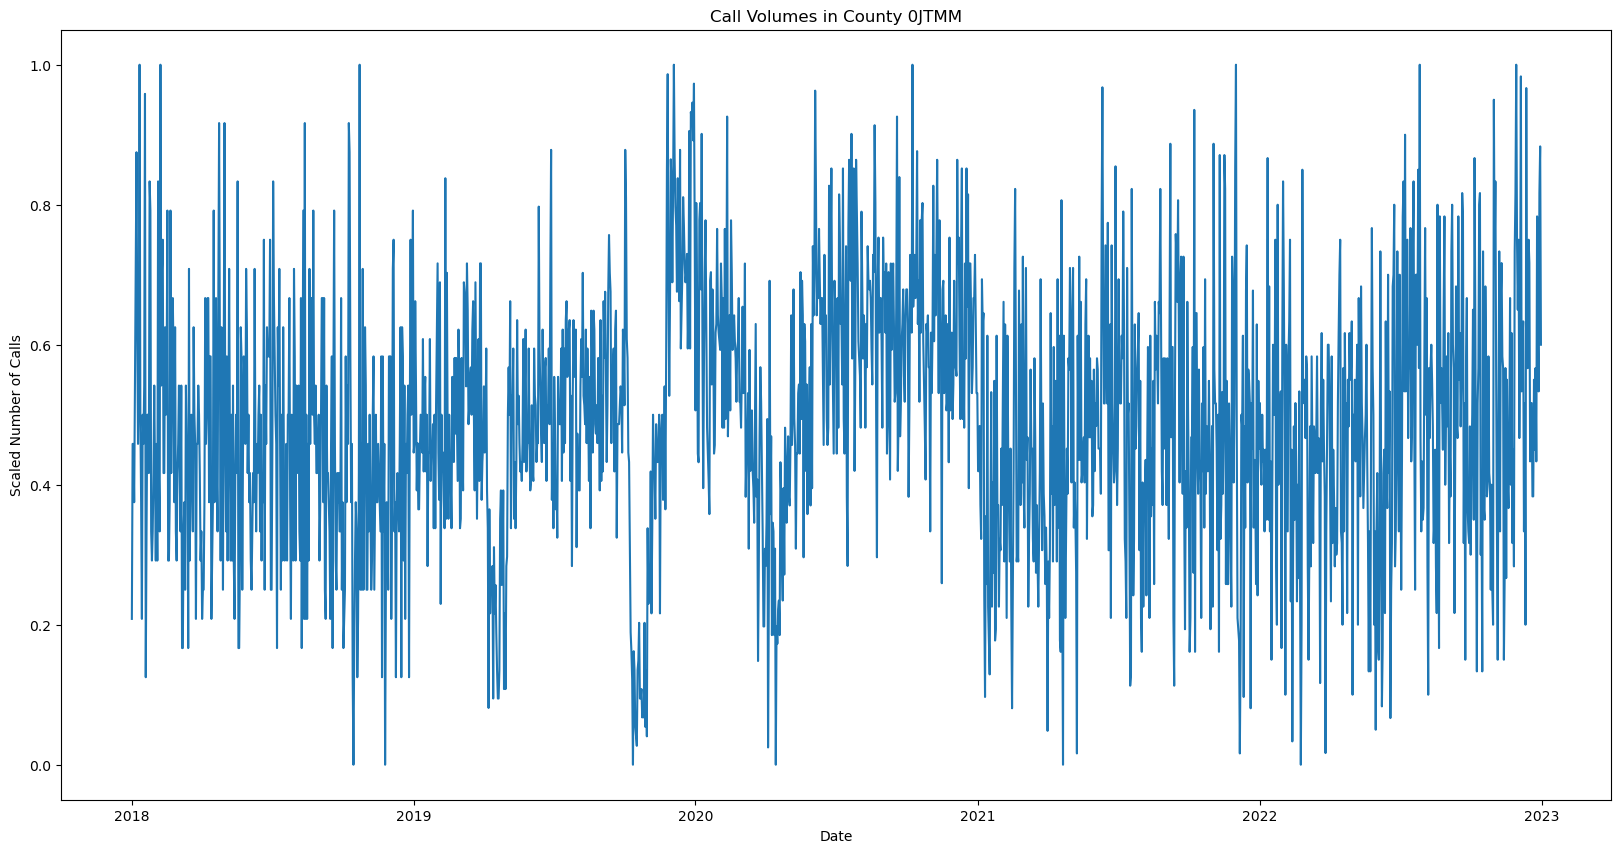

In [51]:
#Plot of the number of calls each day
plt.figure(figsize=(20,10))
plt.plot(data['date'], data['count'])
plt.title('Call Volumes in County 0JTMM')
plt.xlabel('Date')
plt.ylabel('Scaled Number of Calls')
plt.show()

In this graph, we see that the call volumes is more stabilized due to scaling each year individually. This allows us to have a stationary data set necessary for fitting the SARIMA models.

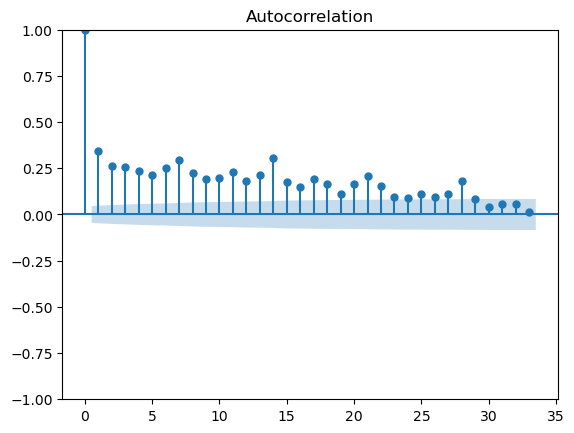

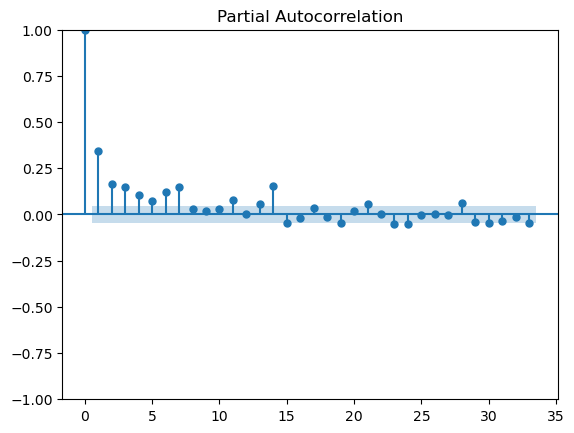

In [52]:
#Modelling
#(partial) autocorrelation plots
# autocorrelation: correlation between x_n and x_{n-i}
# partial ac: correlation between the linear combination of x_{n,n-1,...n-i+1} and x_{n-i}
# useful in finding parameters p and q
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['count'])
plot_pacf(data['count'], method='ywm')
#ax1.tick_params(axis='both', labelsize=12)
#ax2.tick_params(axis='both', labelsize=12)
plt.show()

## Observations about autocorrelation

PACF displays signigicant lags at multiples of 7, which implies a weekly seasonality. 

## Model selection using the Akaike information Criterion (AIC)

The `auto_arima` function searches through ARIMA models and computes the AIC, which estimates prediction error and allows us to weigh the relative quality of certain models. We will select 3 models with low AIC values and compare them using cross validation.

In [53]:
from pmdarima import auto_arima
auto_arima(data['count'], trace=True, start_p=1,max_d=2, start_q=1, max_p=8, max_q=8, start_P=0, start_Q=1, max_D=2, max_P=8, max_Q=8, m=7, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-445.924, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-454.637, Time=0.20 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-494.895, Time=0.54 sec
 ARIMA(0,1,0)(0,0,3)[7] intercept   : AIC=-496.068, Time=2.09 sec
 ARIMA(0,1,0)(0,0,4)[7] intercept   : AIC=-511.895, Time=3.16 sec
 ARIMA(0,1,0)(0,0,5)[7] intercept   : AIC=-513.224, Time=4.94 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-458.175, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(0,1,0)(1,0,3)[7] intercept   : AIC=inf, Time=7.70 sec
 ARIMA(0,1,0)(1,0,4)[7] intercept   : AIC=inf, Time=12.02 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-506.748, Time=0.50 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(2,0,3)[7] intercept   : AIC=inf, Time=9.17 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : AIC=-5

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 0, 1, 7),
      suppress_warnings=True)

## Model Comparison
We will compare some models using time series cross validation
- Model 0: baseline naive forecast
- Model 1: SARIMA model 011 301 7
- Model 2: SARIMA model 111 201 7
- Model 3: SARIMA model 012 201 7

Note that in each of the SARIMA models, the sum of the parameters is the same, so none of them are advantaged against one another in terms of overfitting. These models were selected by the `auto_arima` search which looked for models minimizing the AIC criterion.

Cross validation scheme:
- forecast horizon of 7 days
- reserve last 10% of data as testing set, so do not look at it during CV
- 10 fold cross validation
    - Fold 1: Train on [:-70], predict [-70:-70-7]
    - $\vdots$
    - Fold 10: Train on [:-7], predict [-7:]

In [ ]:
model0_preds = [] #naive
model1_preds = [] #custom arima 011 3017
model2_preds = [] #custom sarima 111 2017
model3_preds = [] #custom sarima 012 2017

for i in range(-10,0):
    y_tt = train['count'].values[:(7*i)]
    y_ho = train['count'].values[(7*i):(7*(i+1))]

    model1=sm.ARIMA(y_tt, order=(0,1,1), seasonal_order=(3,0,1,7)).fit()
    model2=sm.ARIMA(y_tt, order=(1,1,1), seasonal_order=(2,0,1,7)).fit()
    model3=sm.ARIMA(y_tt, order=(0,1,2), seasonal_order=(2,0,1,7)).fit()

    model0_preds.append(y_tt[-1]*np.ones(7))

    model1_preds.append(model1.forecast(7)) #use predict for autoarima
    

    model2_preds.append(model2.forecast(7)) #use forecast for statsmodel
    

    model3_preds.append(model3.forecast(7))

c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Kar

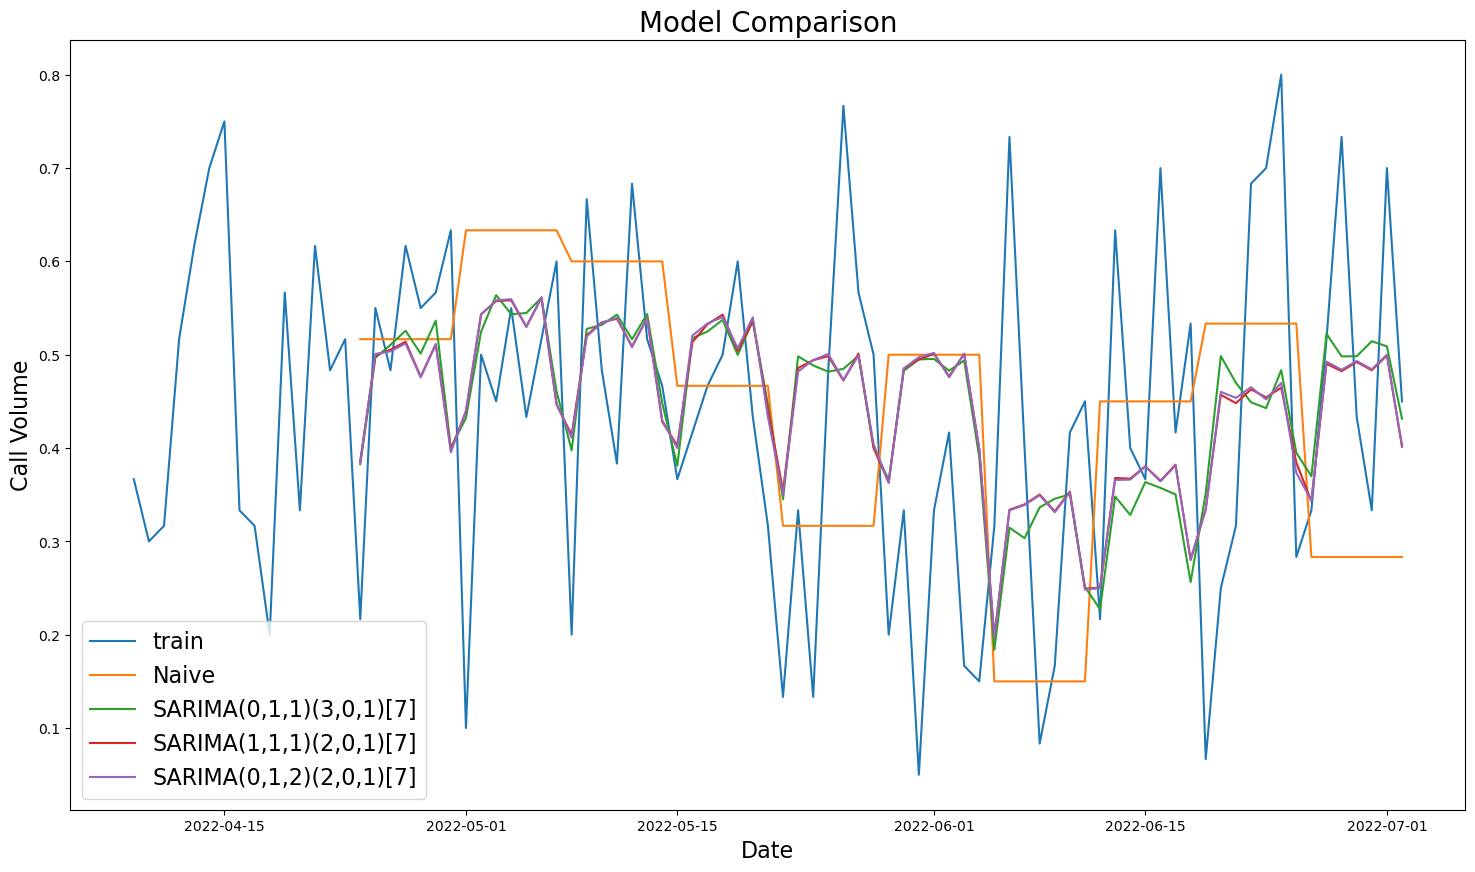

In [75]:
#adjust
plt.figure(figsize=(18,10))
plt.plot(train['date'][-85:], train['count'][-85:], label='train')
plt.plot(train['date'][-70:], np.concatenate(model0_preds), label = 'Naive')
plt.plot(train['date'][-70:], np.concatenate(model1_preds), label = 'SARIMA(0,1,1)(3,0,1)[7]')
plt.plot(train['date'][-70:], np.concatenate(model2_preds), label = 'SARIMA(1,1,1)(2,0,1)[7]')
plt.plot(train['date'][-70:], np.concatenate(model3_preds), label = 'SARIMA(0,1,2)(2,0,1)[7]')
plt.title('Model Comparison', fontsize=20)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Call Volume',fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error as mse

mse0 = mse(train['count'][-70:],np.concatenate(model0_preds))
mse1 = mse(train['count'][-70:],np.concatenate(model1_preds))
mse2 = mse(train['count'][-70:],np.concatenate(model2_preds))
mse3 = mse(train['count'][-70:],np.concatenate(model3_preds))

unordered_dict = {'Model 0':mse0, 'Model 1':mse1, 'Model 2':mse2, 'Model 3':mse3}
ordered_dict = dict(sorted(unordered_dict.items(), key=lambda item: item[1], reverse=True))
ordered_dict

{'Model 0': np.float64(0.051289682539682545),
 'Model 1': np.float64(0.03308408924097655),
 'Model 2': np.float64(0.03244400018275592),
 'Model 3': np.float64(0.032400499604615184)}

We see that Model 0 (naive forecast) had the largest MSE, and all three selected SARIMA models cut the error by over a third. The SARIMA(1,2,2)(2,0,1)[7] performed the best.